In [1]:
device = "mps"


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tqdm.notebook as tqdm
from torchmetrics.image.fid import FrechetInceptionDistance
import diffusers
import matplotlib.pyplot as plt


In [3]:
train_dataset = torchvision.datasets.MNIST(root="data", train=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((32,32))
]))
test_dataset = torchvision.datasets.MNIST(root="data", train=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((32,32))
]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


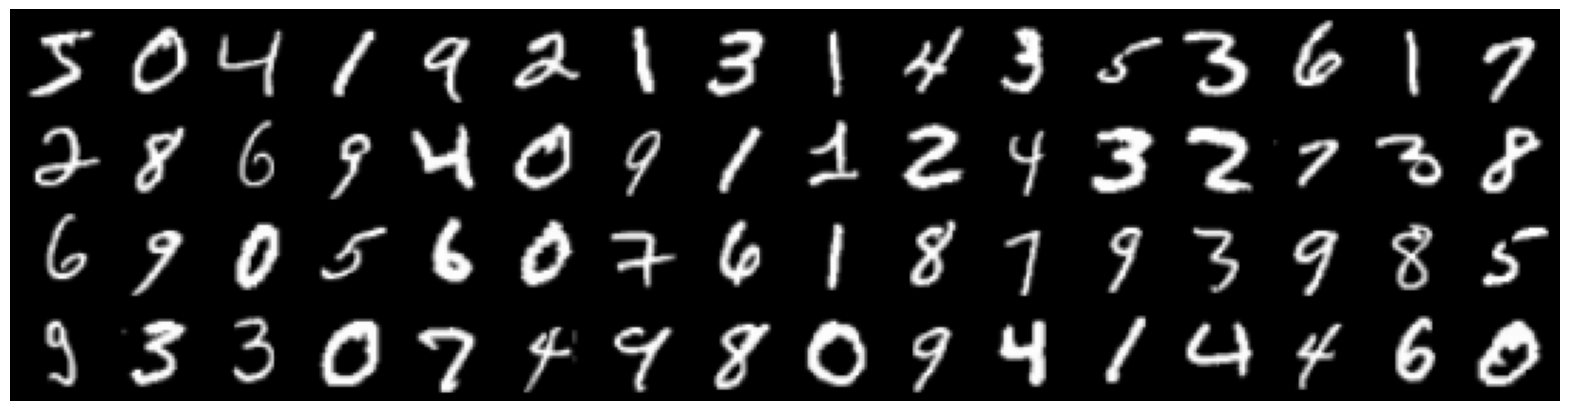

In [4]:
x, y = next(iter(test_loader))

grid = torchvision.utils.make_grid(x, nrow=16)

plt.figure(figsize=(20,20))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()


In [7]:
model = diffusers.UNet2DConditionModel(
    sample_size=(32, 32),
    in_channels=1,
    out_channels=1,
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    ),  # "DownBlock2D", "CrossAttnDownBlock2D",
    up_block_types=(
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),  # "UpBlock2D", "CrossAttnUpBlock2D",
    attention_head_dim=1,
    block_out_channels=(32, 64, 128),
    layers_per_block=2,
    num_class_embeds=10,
).to(device)

num_train_steps = 0
print(f"Model has {model.num_parameters():,}")


Model has 7,491,137


In [ ]:
scheduler = diffusers.DDIMScheduler(
    num_train_timesteps=4000,
    rescale_betas_zero_snr=True
)


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=4e-5)
criterion = torch.nn.MSELoss()


  0%|          | 0/1 [00:00<?, ?it/s]

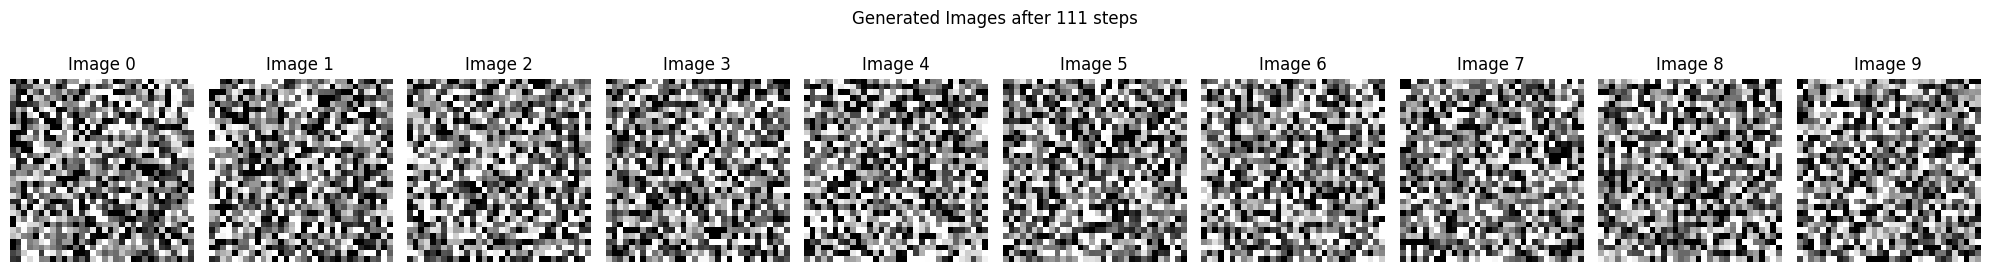

In [12]:
@torch.no_grad()
def generate(batch_size, eta, num_inference_steps):
    image = torch.randn(batch_size, 1, 32, 32, device=device)
    classes = torch.arange(10, device=device)
    # set step values
    scheduler.set_timesteps(num_inference_steps)

    for t in tqdm.tqdm(range(num_inference_steps)):
        # 1. predict noise model_output
        model_output = model(image, t, classes).sample

        # 2. predict previous mean of image x_t-1 and add variance depending on eta
        # eta corresponds to η in paper and should be between [0, 1]
        # do x_t -> x_t-1
        image = scheduler.step(
            model_output,
            t,
            image,
            eta=eta,
        ).prev_sample

    imgs = (image / 2 + 0.5).clamp(0, 1).cpu()

    plt.figure(figsize=(20, 3))

    for i in range(batch_size):
        plt.subplot(1, batch_size, i + 1)
        plt.imshow(imgs[i].squeeze(), cmap="gray")
        plt.title(f"Number {classes[i]}")
        plt.axis("off")
        
    plt.suptitle(f"Generated Images after {num_train_steps:,} steps")
    plt.font_size = 28
    plt.tight_layout()
    plt.axis("off")
    plt.show()


generate(10, 1, 1)


In [14]:
pbar = tqdm.trange(10, desc="Epochs", unit="epochs")

for epoch in pbar:
    if num_train_steps > 10000:
            break
    for x, y in tqdm.tqdm(train_loader, desc="Batches", unit="batches", leave=False):
        x = x.to(device)
        y = y.to(device)
        
        t = torch.randint(0, scheduler.config.num_train_timesteps, (x.size(0),), device=device).long()
        noise = torch.randn_like(x, device=device)

        noisy_x = scheduler.add_noise(x, noise, t)

        pred = model.forward(noisy_x, t, y).sample

        loss = criterion(pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_train_steps += 1

        pbar.set_postfix_str(f"Total Steps: {num_train_steps:,}, Loss: {loss:.4f}")

        if num_train_steps % 500 == 0:
            generate(10, 1, 50)
            


Epochs:   0%|          | 0/10 [00:00<?, ?epochs/s]

Batches:   0%|          | 0/938 [00:00<?, ?batches/s]

KeyboardInterrupt: 

  0%|          | 0/50 [00:00<?, ?it/s]

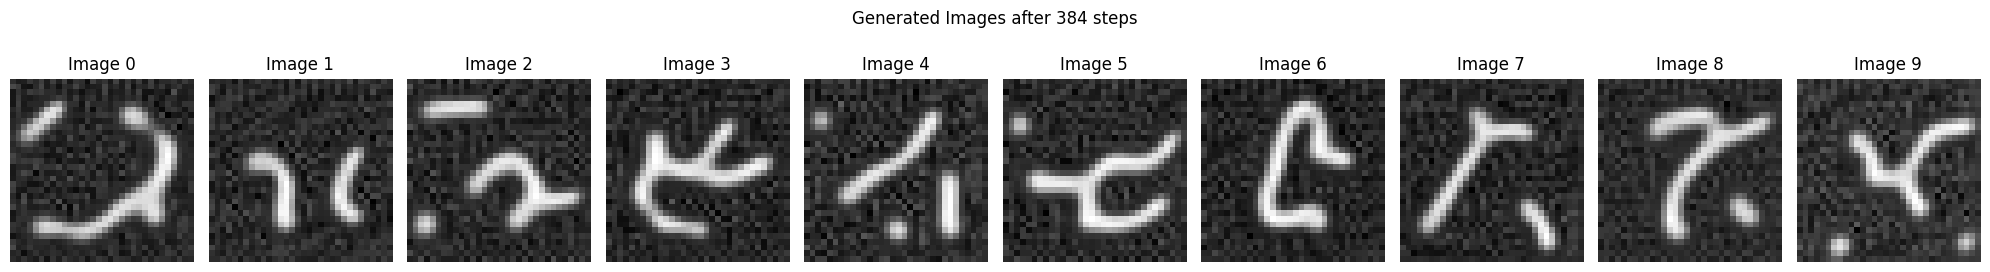

In [15]:
generate(10, 1, 50)


In [ ]:
with torch.no_grad():
    pipeline = diffusers.DiffusionPipeline(model, scheduler).to(device)
    print(pipeline)


In [ ]:
#Validation
def validate():
    pbar = tqdm.tqdm(test_loader, desc="Validation", unit="batch", leave=False)
    for x, _ in pbar:
        x = x.to(device)
        t = torch.randint(0, 1000, (x.size(0),), device=device).long()
        noise = torch.randn_like(x, device=device)

        noisy_x = scheduler.add_noise(x, noise, t)

        pred = model.forward(noisy_x, t).sample

        loss = criterion(pred, noise)

        pbar.set_postfix_str(f"Total Steps: {num_train_steps:,}, Loss: {loss:.4f}")

    generate(16, 0, 50)

validate()


In [ ]:
torch.save(model.state_dict(), "projects/paper-implementations/image-generation/7-ddpm/models/mnist1.pth")


In [ ]:
with torch.no_grad():
    fid = FrechetInceptionDistance(feature=2048)
    pipeline = diffusers.DDIMPipeline(model, scheduler).to(device)
    pbar = tqdm.tqdm(test_loader, desc="FID", unit="batch", leave=False)
    
    fids = []
    for i in pbar:
        imgs = pipeline(100, eta=1, num_inference_steps=50, output_type="np").images
        imgs = torch.as_tensor(imgs).permute(0, 3, 1, 2)
        
        x, y = next(iter(test_loader))
        x = x.to(device)
        
        imgs = F.interpolate(imgs, size=(299, 299), mode="bilinear", align_corners=False)
        x = F.interpolate(x, size=(299, 299), mode="bilinear", align_corners=False)
        
        # Convert to UINT8
        imgs = (imgs * 255).clamp(0, 255).to(torch.uint8)
        x = (x * 255).clamp(0, 255).to(torch.uint8)
        
        fid.update(imgs, False)
        fid.update(x, True)
        
        fids.append(fid.compute().item())
        
        pbar.set_postfix_str(f"FID: {fids[-1]:.2f}")
